In [1]:
import os 
from os.path import join as pjoin 

import pandas as pd
import numpy as np

DATA_DIR = '../../data'
os.environ['DATA_DIR'] = DATA_DIR


In [2]:
def read_ground_truth(sample_id):
    truth = pd.read_csv(pjoin(DATA_DIR, 'quality', f'sample_with_true_source_{sample_id}.csv'))
    return truth

def read_prediction_0():
    pred = pd.read_excel(pjoin(DATA_DIR, 'quality', f'sample_0_pred.xlsx'), header=1)[['index', 'judgment']]
    return pred

def read_prediction_1():
    pred = pd.read_csv(pjoin(DATA_DIR, 'quality', f'sample_1_pred.csv'), header=0)[['index', 'judgment']]
    pred["judgment"] = pd.to_numeric(pred["judgment"])
    return pred

def merge_truth_and_pred(truth, pred):
    return truth.merge(pred, on='index')

In [3]:
def calc_relative_number_of_sensible_features(df):
    # calc relative number of features that are marked as sensible (1 or 2)
    # use bootstrap to calculate 95% CI

    def calc_for_sample(judgements, n_features):
        n_features_marked_as_sensible = len([judgement for judgement in judgements if judgement == 1 or judgement == 2])
        acc = n_features_marked_as_sensible / n_features * 100
        return acc
    
    judgements = df['judgment']
    n_features = df.shape[0]
    
    values = []
    for i in range(1000):
        judgements_bootstrap_sample = np.random.choice(judgements, n_features, replace=True)
        values.append(calc_for_sample(judgements_bootstrap_sample, n_features))

    sample_value = calc_for_sample(judgements, n_features)

    return (sample_value, np.asarray(values).std() * 1.96)

def show(result):
    rows = []
    for source in ['human', 'gpt']:
        result_source = result[result['source'] == source]
        sample_acc, ci = calc_relative_number_of_sensible_features(result_source)
        print(f'{source}: {sample_acc:.2f} +- {ci:.2f}%  are marked with 1/2 (sensible)')
        rows.append({'source': source, 'acc': sample_acc, 'ci': ci})
    
    df_human_gpt = pd.DataFrame(rows)

    rows = []
    for name in ['gpt_3_filtered', 'gpt_3_unfiltered', 'mcrae', 'cslb', 'gpt_3_filtered_overlap']:
        result_source = result[result['name'] == name]
        sample_acc, ci = calc_relative_number_of_sensible_features(result_source)
        print(f'{name}: {sample_acc:.2f} +- {ci:.2f}% are marked with 1/2 (sensible)')
        rows.append({'source': name, 'acc': sample_acc, 'ci': ci})
    
    df_fine = pd.DataFrame(rows)

    return df_human_gpt, df_fine


# Reviewer 1

In [4]:
truth = read_ground_truth(0)
pred = read_prediction_0()
result1 = merge_truth_and_pred(truth, pred)
result1

,index,concept_id,feature,name,source,judgment
0,0,camcorder,is used to make movies,gpt_3_filtered,gpt,1
1,1,duck,is domestic,gpt_3_filtered_overlap,gpt,1
2,2,eggplant,grows in the ground,gpt_3_filtered,gpt,1
3,3,belt,is decorative,mcrae,human,2
4,4,broccoli,is found in supermarkets,gpt_3_filtered_overlap,gpt,2
...,...,...,...,...,...,...
1495,1495,tray,is square,mcrae,human,1
1496,1496,crayfish,has eyes,gpt_3_unfiltered,gpt,1
1497,1497,rock,is small,cslb,human,2
1498,1498,boots,is for men,cslb,human,2


## Explore

<AxesSubplot:>

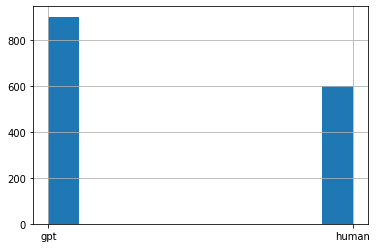

In [5]:
truth['source'].hist()

<AxesSubplot:>

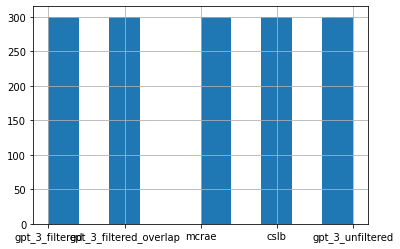

In [6]:
truth['name'].hist()

In [7]:
d = truth[['concept_id', 'feature']].duplicated()

In [8]:
df_human_gpt, df_fine = show(result1)

human: 92.67 +- 2.06%  are marked with 1/2 (sensible)
gpt: 89.11 +- 2.01%  are marked with 1/2 (sensible)
gpt_3_filtered: 88.33 +- 3.54% are marked with 1/2 (sensible)
gpt_3_unfiltered: 90.00 +- 3.43% are marked with 1/2 (sensible)
mcrae: 94.67 +- 2.56% are marked with 1/2 (sensible)
cslb: 90.67 +- 3.43% are marked with 1/2 (sensible)
gpt_3_filtered_overlap: 89.00 +- 3.50% are marked with 1/2 (sensible)


In [9]:
df_human_gpt

,source,acc,ci
0,human,92.666667,2.064568
1,gpt,89.111111,2.010644


In [10]:
df_fine

,source,acc,ci
0,gpt_3_filtered,88.333333,3.535225
1,gpt_3_unfiltered,90.000000,3.432260
2,mcrae,94.666667,2.558280
3,cslb,90.666667,3.427913
4,gpt_3_filtered_overlap,89.000000,3.501504


# Reviewer 2

In [22]:
truth = read_ground_truth(1)
pred = read_prediction_1()
result2 = merge_truth_and_pred(truth, pred)
result2[result2['judgment'] == 3.0].head(30)

,index,concept_id,feature,name,source,judgment
7,7,motorcycle,has a seatbelt,gpt_3_filtered_overlap,gpt,3.0
29,29,outlet,is used to cook,gpt_3_filtered,gpt,3.0
32,32,swimsuit,is made of silk,gpt_3_filtered_overlap,gpt,3.0
33,33,hamburger,is cooked in an oven,gpt_3_filtered,gpt,3.0
45,45,shoes,has toes,cslb,human,3.0
56,56,cork,is used in the bath,gpt_3_filtered_overlap,gpt,3.0
57,57,coral,is a mineral,gpt_3_filtered,gpt,3.0
81,81,eagle,is used in the army,gpt_3_filtered,gpt,3.0
82,82,banjo,is yellow,gpt_3_filtered,gpt,3.0
90,90,thermos,is made of glass,gpt_3_filtered,gpt,3.0


In [12]:
df_human_gpt, df_fine = show(result2)

human: 97.33 +- 1.25%  are marked with 1/2 (sensible)
gpt: 87.89 +- 2.06%  are marked with 1/2 (sensible)
gpt_3_filtered: 87.67 +- 3.61% are marked with 1/2 (sensible)
gpt_3_unfiltered: 89.00 +- 3.49% are marked with 1/2 (sensible)
mcrae: 98.67 +- 1.31% are marked with 1/2 (sensible)
cslb: 96.00 +- 2.28% are marked with 1/2 (sensible)
gpt_3_filtered_overlap: 87.00 +- 3.63% are marked with 1/2 (sensible)


In [13]:
df_human_gpt

,source,acc,ci
0,human,97.333333,1.251129
1,gpt,87.888889,2.055208


In [14]:
df_fine

,source,acc,ci
0,gpt_3_filtered,87.666667,3.608054
1,gpt_3_unfiltered,89.000000,3.487728
2,mcrae,98.666667,1.314626
3,cslb,96.000000,2.276074
4,gpt_3_filtered_overlap,87.000000,3.628646


# Both Reviewers

In [15]:
a = result1.drop_duplicates(['concept_id', 'feature'])
b = result2.drop_duplicates(['concept_id', 'feature'])
b = b[['concept_id', 'feature', 'judgment']]

merged_reviewers = pd.merge(a, b, on=['concept_id', 'feature'])
merged_reviewers

,index,concept_id,feature,name,source,judgment_x,judgment_y
0,0,camcorder,is used to make movies,gpt_3_filtered,gpt,1,1.0
1,4,broccoli,is found in supermarkets,gpt_3_filtered_overlap,gpt,2,1.0
2,9,hoe,is used to kill animals,gpt_3_filtered_overlap,gpt,2,2.0
3,15,throne,has arms,cslb,human,1,1.0
4,16,pipe1,made of bone,cslb,human,1,2.0
...,...,...,...,...,...,...,...
511,1489,dragonfly,has big eyes,cslb,human,1,1.0
512,1490,lamb,has curly hair,gpt_3_filtered_overlap,gpt,1,1.0
513,1492,cabbage,is green,mcrae,human,1,1.0
514,1496,crayfish,has eyes,gpt_3_unfiltered,gpt,1,1.0


In [16]:
total = pd.concat([result1, result2])
total.drop_duplicates(['concept_id', 'feature'])

,index,concept_id,feature,name,source,judgment
0,0,camcorder,is used to make movies,gpt_3_filtered,gpt,1.0
1,1,duck,is domestic,gpt_3_filtered_overlap,gpt,1.0
2,2,eggplant,grows in the ground,gpt_3_filtered,gpt,1.0
3,3,belt,is decorative,mcrae,human,2.0
4,4,broccoli,is found in supermarkets,gpt_3_filtered_overlap,gpt,2.0
...,...,...,...,...,...,...
1493,1493,sultana,is food,cslb,human,1.0
1494,1494,screwdriver,is useful,cslb,human,1.0
1496,1496,chair,has four legs,gpt_3_filtered_overlap,gpt,1.0
1497,1497,raspberry,is soft,gpt_3_filtered_overlap,gpt,1.0


In [ ]:
print(f'Total of {total.shape[0]} concept-feature pairs were judged')

In [17]:
df_human_gpt, df_fine = show(total)

human: 95.00 +- 1.25%  are marked with 1/2 (sensible)
gpt: 88.50 +- 1.56%  are marked with 1/2 (sensible)
gpt_3_filtered: 88.00 +- 2.53% are marked with 1/2 (sensible)
gpt_3_unfiltered: 89.50 +- 2.47% are marked with 1/2 (sensible)
mcrae: 96.67 +- 1.35% are marked with 1/2 (sensible)
cslb: 93.33 +- 1.94% are marked with 1/2 (sensible)
gpt_3_filtered_overlap: 88.00 +- 2.60% are marked with 1/2 (sensible)


In [18]:
df_human_gpt

,source,acc,ci
0,human,95.0,1.247426
1,gpt,88.5,1.558191


In [19]:
df_fine

,source,acc,ci
0,gpt_3_filtered,88.000000,2.531454
1,gpt_3_unfiltered,89.500000,2.472070
2,mcrae,96.666667,1.349824
3,cslb,93.333333,1.939522
4,gpt_3_filtered_overlap,88.000000,2.603615
